In [1]:
import os
import os.path as osp
join = osp.join
import numpy as np
from glob import glob
import torch
from segment_anything import sam_model_registry
from tqdm import tqdm
import argparse
import SimpleITK as sitk
import torch.nn.functional as F
from torch.utils.data import DataLoader
import SimpleITK as sitk
import torchio as tio
import numpy as np
from collections import OrderedDict, defaultdict
import json
import pickle
from itertools import product

from torchio.data.io import sitk_to_nib

from IPython.display import clear_output
import time

# Remake predictor example

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from utils.modelUtils import load_sam
from classes.SAMClass import SAMWrapper, SAMInferer

from utils.base_classes import Points
import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

In [2]:
from utils.modelUtils import load_sammed2d
from classes.SAMMed2DClass import SAMMed2DInferer, SAMMed2DWrapper
from utils.base_classes import Points

import utils.analysisUtils as anUt
import utils.promptUtils as prUt
from utils.imageUtils import read_im_gt


# Obtain model, image, gt
device = 'cuda'
sammed2d_checkpoint_path = "/home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth"

sammed2d_model = load_sammed2d(sammed2d_checkpoint_path, device)
sammed2d_wrapper = SAMMed2DWrapper(sammed2d_model, device)
sammed2d_inferer = SAMMed2DInferer(sammed2d_wrapper)

True
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth


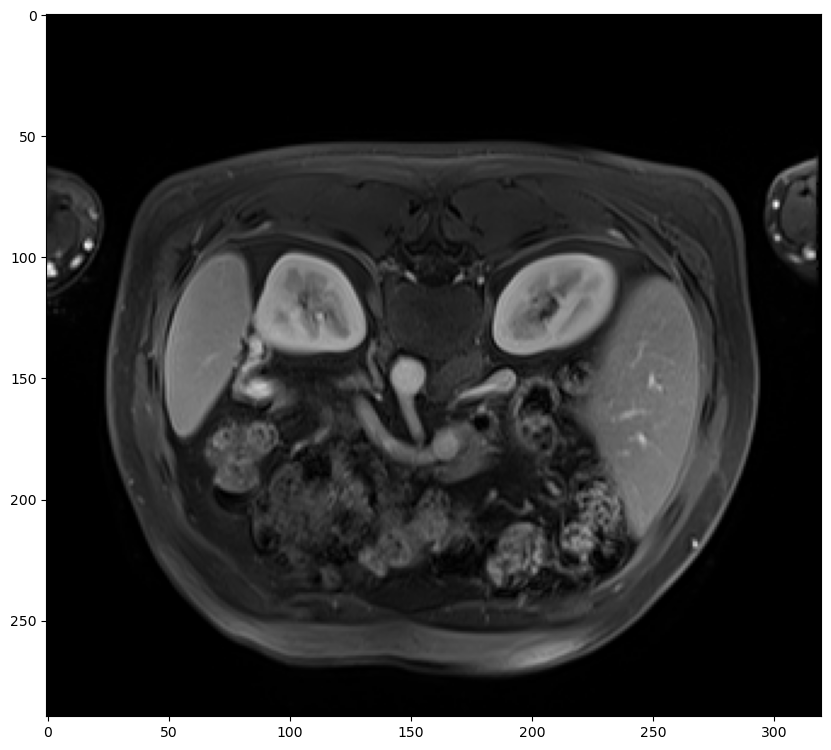

In [3]:
image = cv2.imread('/home/t722s/Desktop/UniversalModels/OtherRepos/SAM-Med2D/data_demo/images/amos_0507_31.png')
image.shape
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [4]:

image = image[:,:,0]
image_3d = np.zeros((128, image.shape[0], image.shape[1]))
image_3d[0] = image

In [5]:
import importlib
import classes.SAMMed2DClass as c
importlib.reload(c)
sammed2d_inferer = c.SAMMed2DInferer(sammed2d_wrapper, device)

from utils.base_classes import Points
input_point = np.array([[162, 127]])
input_label = np.array([1])
input_point_3d = np.array([[0, 127, 162]])
prompt = Points({'coords': input_point_3d,'labels': input_label})

segmentation = sammed2d_inferer.predict(image_3d, prompt)

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


In [1]:
import pickle 
with open('/home/t722s/Desktop/test/logits.pkl', 'rb') as f:
    logits = pickle.load(f)
with open('/home/t722s/Desktop/test/low_res.pkl', 'rb') as f:
    low_res = pickle.load(f)
with open('/home/t722s/Desktop/test/inputs.pkl', 'rb') as f:
    inputs_original = pickle.load(f)
with open('/home/t722s/Desktop/test/input_image.pkl', 'rb') as f:
    input_image = pickle.load(f)

In [2]:
inputs_original[0][0,0,0,0].detach().numpy()

array(-0.02284016, dtype=float32)

In [3]:
sammed2d_wrapper.image_embedding.cpu()[0,0,0,0].numpy()# == inputs_original[0]#
# sammed2d_wrapper.sparse_embeddings.cpu() == inputs_original[1]#, 
# sammed2d_wrapper.dense_prompt_embeddings.cpu()== inputs_original[2]#, 

NameError: name 'sammed2d_wrapper' is not defined

In [64]:
def postprocess_masks(low_res_masks, image_size, original_size):
    masks = F.interpolate(low_res_masks,(image_size, image_size), mode="bilinear", align_corners=False)
    masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
    return masks

low_res_new = sammed2d_inferer.low_res_masks
low_res

postprocess_masks(low_res, 256, (290, 320)).cpu().numpy()[0,0] 


array([[-23.242025, -23.242025, -23.22533 , ..., -23.54018 , -23.646408,
        -23.646408],
       [-23.242025, -23.242025, -23.22533 , ..., -23.54018 , -23.646408,
        -23.646408],
       [-23.286386, -23.286386, -23.27966 , ..., -23.512646, -23.614775,
        -23.614775],
       ...,
       [-22.27172 , -22.27172 , -22.252949, ..., -19.707989, -19.729948,
        -19.729948],
       [-22.46902 , -22.46902 , -22.434494, ..., -20.034077, -20.061068,
        -20.061068],
       [-22.46902 , -22.46902 , -22.434494, ..., -20.034077, -20.061068,
        -20.061068]], dtype=float32)

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [14]:
s = segmentation[0]

In [33]:
s

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

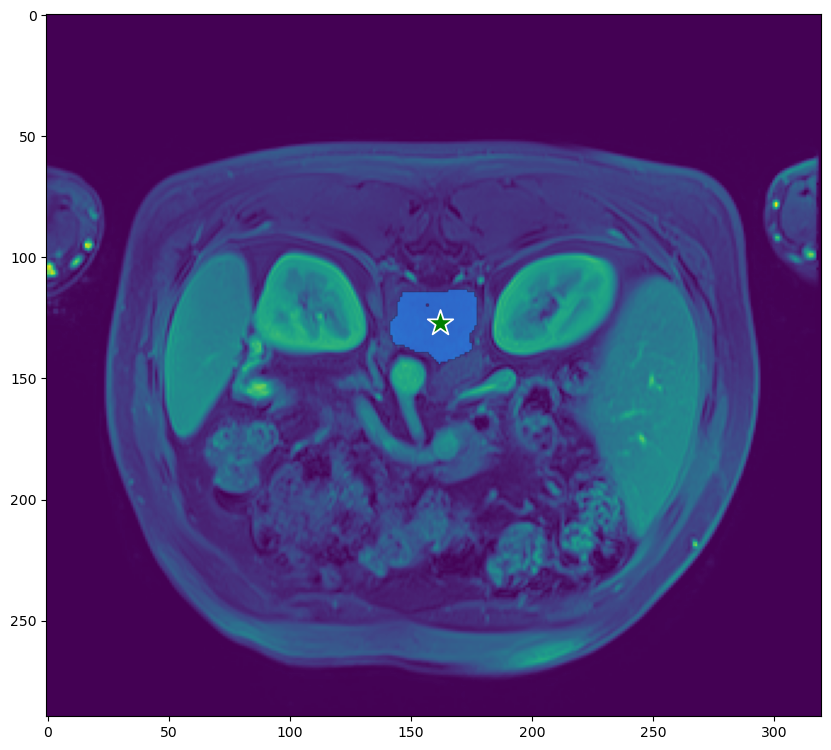

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
show_mask(s, plt.gca())
plt.show()  
